In [6]:
import re
import nltk
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [7]:
#  Download NLTK Resources
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("punkt_tab", quiet=True) # Added punkt_tab download

True

In [8]:
df = pd.read_csv("/content/IMDBDataset.csv", engine='python', on_bad_lines='skip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
df.shape

(50000, 2)

In [10]:
# If sentiment is 'positive'/'negative', map it to 1 and 0
if df["sentiment"].dtype == 'object':
    df["sentiment"] = df["sentiment"].map({"positive": 1, "negative": 0})

print("\nClass distribution:\n", df["sentiment"].value_counts())



Class distribution:
 sentiment
1    25000
0    25000
Name: count, dtype: int64


In [11]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)  # remove HTML tags
    text = re.sub(r"[^a-z0-9\s']", " ", text)  # remove non-alphanumeric
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 1]
    return " ".join(tokens)

print("\n🧹 Cleaning text data (this may take a few minutes)...")
df["clean_review"] = df["review"].apply(clean_text)


🧹 Cleaning text data (this may take a few minutes)...


In [12]:
df

,review,sentiment,clean_review
0,One of the other reviewers has mentioned that ...,1,one reviewer mentioned watching oz episode 'll...
1,A wonderful little production. <br /><br />The...,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,basically 's family little boy jake think 's z...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei 's love time money visually stun...
...,...,...,...
49995,I thought this movie did a down right good job...,1,thought movie right good job n't creative orig...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,0,catholic taught parochial elementary school nu...
49998,I'm going to have to disagree with the previou...,0,'m going disagree previous comment side maltin...


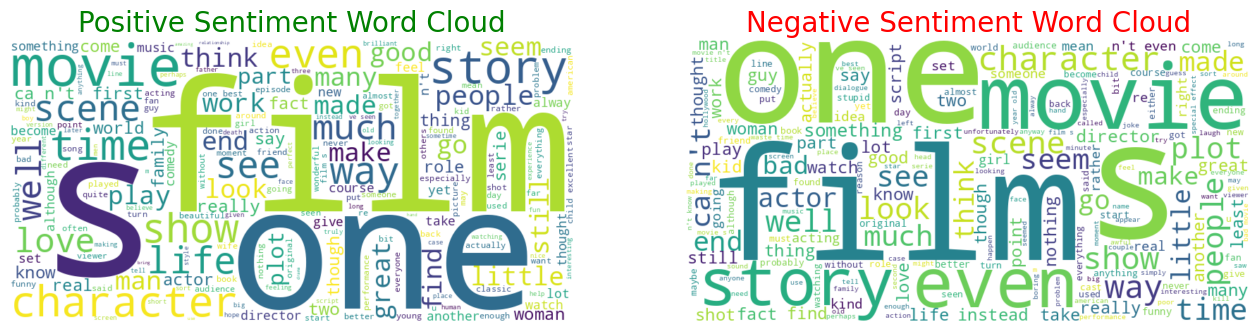

In [13]:
from wordcloud import WordCloud

# Separate positive and negative texts
positive_text = " ".join(df[df['sentiment'] == 1]['clean_review'])
negative_text = " ".join(df[df['sentiment'] == 0]['clean_review'])

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white').generate(negative_text)

# Plotting
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Sentiment Word Cloud', fontsize=20, color='green')

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Sentiment Word Cloud', fontsize=20, color='red')

plt.show()

In [14]:
X = df["clean_review"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData Split -> Train: {len(X_train)}, Test: {len(X_test)}")



Data Split -> Train: 40000, Test: 10000


In [15]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("\nTF-IDF feature matrix shape:", X_train_tfidf.shape)


TF-IDF feature matrix shape: (40000, 20000)


In [16]:
# Convert to dense (NumPy array)
dense_sample = X_train_tfidf.todense()

# Print first few rows and columns
print(dense_sample[:5, :10])


[[0.         0.         0.         0.         0.05531822 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


In [17]:
#models
models = {
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}
results = []

for name, model in models.items():
    print(f"\n Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    print(f" {name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))

    # Save model
    joblib.dump(model, f"{name.replace(' ', '_')}_model.joblib")
    results.append({"Model": name, "Accuracy": acc})



 Training Logistic Regression...
 Logistic Regression Accuracy: 0.8993
              precision    recall  f1-score   support

           0     0.9090    0.8874    0.8981      5000
           1     0.8900    0.9112    0.9005      5000

    accuracy                         0.8993     10000
   macro avg     0.8995    0.8993    0.8993     10000
weighted avg     0.8995    0.8993    0.8993     10000


 Training Naive Bayes...
 Naive Bayes Accuracy: 0.8762
              precision    recall  f1-score   support

           0     0.8902    0.8582    0.8739      5000
           1     0.8631    0.8942    0.8784      5000

    accuracy                         0.8762     10000
   macro avg     0.8767    0.8762    0.8762     10000
weighted avg     0.8767    0.8762    0.8762     10000


 Training Random Forest...
 Random Forest Accuracy: 0.8655
              precision    recall  f1-score   support

           0     0.8650    0.8662    0.8656      5000
           1     0.8660    0.8648    0.8654      


 Model Performance Summary:
                  Model  Accuracy
0  Logistic Regression    0.8993
1          Naive Bayes    0.8762
2        Random Forest    0.8655


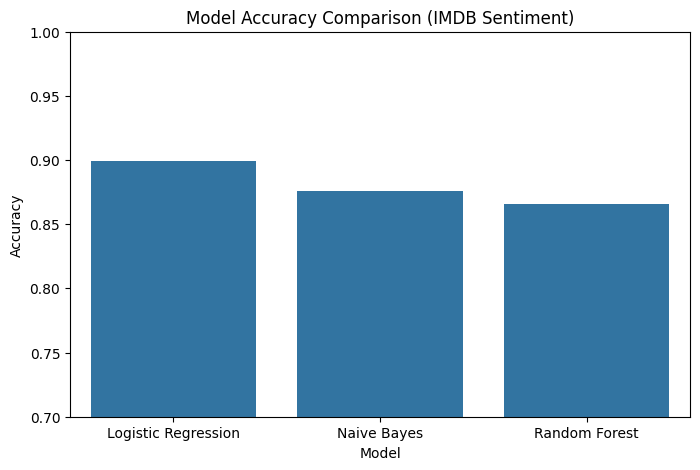

In [18]:
# Compare Results
results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print("\n Model Performance Summary:\n", results_df)

plt.figure(figsize=(8, 5))
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title("Model Accuracy Comparison (IMDB Sentiment)")
plt.ylim(0.7, 1.0)
plt.show()

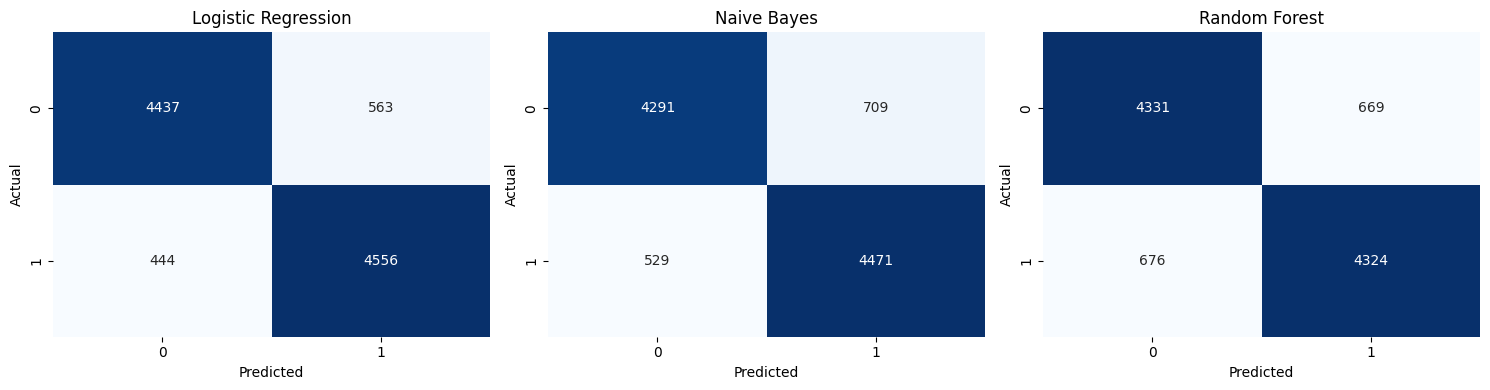


📊 Model Performance Comparison:

                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.8993     0.8900  0.9112    0.9005
1          Naive Bayes    0.8762     0.8631  0.8942    0.8784
2        Random Forest    0.8655     0.8660  0.8648    0.8654


In [19]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# List of model names (make sure filenames match)
models = ["Logistic Regression", "Naive Bayes", "Random Forest"]

# Store metrics for each model
results = []

# Plot setup for confusion matrices
fig, axes = plt.subplots(1, len(models), figsize=(15, 4))

for ax, model_name in zip(axes, models):
    # Load each model
    model = joblib.load(f"{model_name.replace(' ', '_')}_model.joblib")

    # Predict on test data
    y_pred = model.predict(X_test_tfidf)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Append to results
    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(model_name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# Adjust layout
plt.tight_layout()
plt.show()

# Create results dataframe
results_df = pd.DataFrame(results)

# Round metrics for readability
results_df = results_df.round(4)

# Display table
print("\n📊 Model Performance Comparison:\n")
print(results_df)


In [20]:
#Save TF-IDF Vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.joblib")
print("\n All models and vectorizer saved successfully!")


 All models and vectorizer saved successfully!


In [21]:
import joblib

model = joblib.load("Logistic_Regression_model.joblib")
tfidf = joblib.load("tfidf_vectorizer.joblib")

text = ["The movie was absolutely wonderful!"]
text_tfidf = tfidf.transform(text)
pred = model.predict(text_tfidf)

print("Predicted Sentiment:", "Positive" if pred[0] == 1 else "Negative")


Predicted Sentiment: Positive


In [22]:
import joblib

model = joblib.load("Logistic_Regression_model.joblib")
tfidf = joblib.load("tfidf_vectorizer.joblib")

text = ["The movie was boring!"]
text_tfidf = tfidf.transform(text)
pred = model.predict(text_tfidf)

print("Predicted Sentiment:", "Positive" if pred[0] == 1 else "Negative")


Predicted Sentiment: Negative


In [23]:
!pip install gradio -q

In [24]:
import gradio as gr
import joblib

# Load the trained model and TF-IDF vectorizer
model = joblib.load("Logistic_Regression_model.joblib")
tfidf = joblib.load("tfidf_vectorizer.joblib")

def predict_sentiment(text):
    """Predicts the sentiment of a given text."""
    if not text:
        return "Please enter some text to analyze."

    # Clean and transform the input text
    cleaned_text = clean_text(text) # Assuming clean_text function is available from previous cells
    text_tfidf = tfidf.transform([cleaned_text])

    # Predict sentiment
    pred = model.predict(text_tfidf)

    return "Positive" if pred[0] == 1 else "Negative"

# Create the Gradio interface
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=5, label="Enter review text"),
    outputs=gr.Textbox(label="Predicted Sentiment"),
    title="IMDB Sentiment Analysis",
    description="Enter a movie review to predict its sentiment (Positive or Negative)."
)

# Launch the interface
interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6f45e9e7274c36d2e8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6f45e9e7274c36d2e8.gradio.live
